In [1]:
# For each sample, exclude cells and bins with too much aneuploidy 

In [2]:
import pandas as pd,numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

In [7]:
samples=glob('*/status.xml')
samples=[i.split('/')[0] for i in samples]

In [8]:
def get_badbins(sample,
                max_frac_aneuploid_per_cell=0.3,
                max_frac_aneuploid_per_bin=[0.2,.85],
               ):
    # Determine bad bins and bad cells for a sample
    #
    
    copies = pd.read_csv(f'{sample}/SegCopy.gz',sep='\t',index_col=['CHR','START','END']).T
    orig_shape=copies.shape

    autosomes = [f'chr{i+1}' for i in np.arange(22)]
    # Global normalization
    copies = copies
    
    badcells = (copies[autosomes]==2).mean(axis=1)<(1-max_frac_aneuploid_per_cell) # Exclude cells with >20% aneuploid bins
    copies = copies.loc[~badcells,:]

    q=[max_frac_aneuploid_per_bin[0], 0.5, max_frac_aneuploid_per_bin[1]]
    copies_quantiles = copies.quantile(q=q)
    copies_quantiles = copies_quantiles.T.reset_index()

    # Correct male chrX. (I checked that this correctly estimates the sex for our CZI samples)
    if copies_quantiles.loc[copies_quantiles['CHR']=='chrX',0.5].median()==1:
        sex='m'
        copies['chrX']=copies['chrX']*2
        copies_quantiles = copies.quantile(q=q)
        copies_quantiles = copies_quantiles.T.reset_index()
#         copies_quantiles.loc[copies_quantiles['CHR']=='chrX',q] *= 2
    else:
        sex='f'

    badbins = ~((copies_quantiles[q[0]]>=2)&(copies_quantiles[q[-1]]<=2))

    # Keep only bins with the canonical binsize
    binsize=int(1e6)
    badbins += (copies_quantiles['END']-copies_quantiles['START']!=binsize-1)

    copies_quantiles.set_index(['CHR','START','END'],inplace=True)
    copiesu = copies.T.loc[~badbins.values]

    copiesu.to_csv(f'{sample}/SegCopy.goodbins.goodcells.tsv.gz',sep='\t')
#     print(f'{sample}\tKeeping {copiesu.shape[0]}/{orig_shape[1]} cells, {copiesu.shape[1]}/{orig_shape[0]} bins')
    
    binstats = pd.Series({'ncells raw':orig_shape[0],'nbins raw':orig_shape[1],
                          'ncells filt':copiesu.shape[1],'nbins filt':copiesu.shape[0],
                         }, name=sample)
#     copiesu = copies.T.iloc[~badbins,:]
#     copiesu = copies.T.loc[:,~copies_quantiles['badbins']]
    return binstats#,copies_quantiles

In [6]:
sample='test'
binstats,copies_quantiles=get_badbins(sample, max_frac_aneuploid_per_bin=[.15,.85])

plt.plot(copies_quantiles.loc['chrX'][0.85].values)

ValueError: too many values to unpack (expected 2)

In [9]:
from multiprocessing import Pool

with Pool() as p:
    binstats = list(tqdm(p.imap(get_badbins, samples),total=len(samples)))

100%|██████████| 6/6 [00:03<00:00,  1.92it/s]


In [10]:
binstats_df = pd.concat(binstats,axis=1).T

In [11]:
binstats_df

,ncells raw,nbins raw,ncells filt,nbins filt
MB_EA,2347,3032,2302,2932
Luo2017_human,2888,3032,2804,2902
MB_v1,2784,3032,2705,2962
MB_EB,1304,3032,1235,2967
mCTN-2,2927,3032,2759,2966
mCTN-1,1446,3032,1369,2953


In [12]:
binstats_df['frac goodcells'] = binstats_df['ncells filt']/binstats_df['ncells raw']
binstats_df['frac goodbins'] = binstats_df['nbins filt']/binstats_df['nbins raw']
# binstats_df['sex'] = binstats_df.index.str.contains('f')
# binstats_df['sex'] = binstats_df['sex'].map({True:'f', False:'m'})

In [14]:
binstats_df

,ncells raw,nbins raw,ncells filt,nbins filt,frac goodcells,frac goodbins
MB_EA,2347,3032,2302,2932,0.980827,0.967018
Luo2017_human,2888,3032,2804,2902,0.970914,0.957124
MB_v1,2784,3032,2705,2962,0.971624,0.976913
MB_EB,1304,3032,1235,2967,0.947086,0.978562
mCTN-2,2927,3032,2759,2966,0.942603,0.978232
mCTN-1,1446,3032,1369,2953,0.946750,0.973945


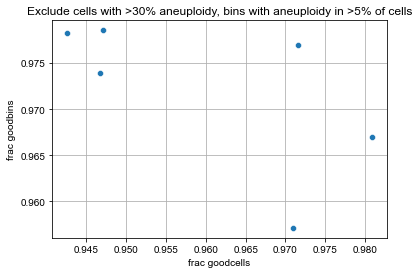

In [17]:
sns.scatterplot(data=binstats_df,
                x='frac goodcells',y='frac goodbins',
#                 hue='Age category',style='Subject Sex',
#                 size='ncells filt',
#                 palette='colorblind',
               )
plt.grid()
plt.title('Exclude cells with >30% aneuploidy, bins with aneuploidy in >5% of cells')
plt.savefig('Plots/Fraction_goodcells.pdf')

# Find bins which should be globally excluded from all samples

In [18]:
df=[]
for sample in tqdm(samples):
    df1=pd.read_csv(f'{sample}/SegCopy.goodbins.goodcells.tsv.gz',sep='\t',usecols=['CHR','START','END'])
    df1['sample']=sample
    df.append(df1)
    
df=df[0].append(df[1:])
df=df.sort_values(['CHR','START','END'])

100%|██████████| 6/6 [00:00<00:00, 11.81it/s]


In [19]:
# Make sure that all samples have representation across chrX and autosomes
df['chrX'] = df['CHR']=='chrX'
df.groupby(['sample','chrX'])['START'].count().unstack()

chrX,False,True
sample,,
Luo2017_human,2748,154
MB_EA,2778,154
MB_EB,2813,154
MB_v1,2808,154
mCTN-1,2799,154
mCTN-2,2812,154


In [20]:
nsamples=binstats_df.shape[0]
all_goodbins = df.groupby(['CHR','START']).count().reset_index().rename(columns={'END':'frac_goodsamples'})
all_goodbins['frac_goodsamples'] = all_goodbins['frac_goodsamples']/nsamples

In [21]:
# Make a plot 
def zebra_stripes(xt,ymax):
    # Show gray and white stripes for chromosomes
    if (xt.shape[0]%2)==1:
        xt=xt[:-1]
    plt.bar(xt[::2],ymax,width=xt[1::2]-xt[::2],
            align='edge',
            color='gray',alpha=0.5)

def chromplot(df,y,x='pos',hue=None,ax=None,sample='',cell=''):
    # Plot the segnorm and segcopy information for a cell
    chroms=list(np.arange(1,23))+['X']
    chroms+=['chr%d'%(i+1) for i in range(23)]+['chrX']
    chroms=np.array(chroms,dtype=str)
    i=0
    xt,chromshow=[],[]
    dfu=df.copy()
    dfu['chrom_pos'] = dfu[x]
    for chrom in chroms:
        df1=df[df['CHR']==chrom]
        if df1.shape[0]>0:
            dfu.loc[dfu['CHR']==chrom,'chrom_pos']+=i
            i=dfu.loc[dfu['CHR']==chrom,'chrom_pos'].max()
            xt.append(i)
            chromshow.append(chrom)
    ymax=dfu[y].max().max()
    zebra_stripes(np.array(xt),ymax)
    if type(y) is not list and type(y) is not tuple:
        y=[y]
    for yi in y:
        sns.scatterplot(data=dfu,x='chrom_pos',y=yi,hue=hue,
                        s=10,edgecolor=None
                       )
    plt.xticks(xt,labels=chromshow,rotation=90)
    plt.xlim([0,dfu['chrom_pos'].max()])

False    2883
True       99
Name: global_badbins, dtype: int64

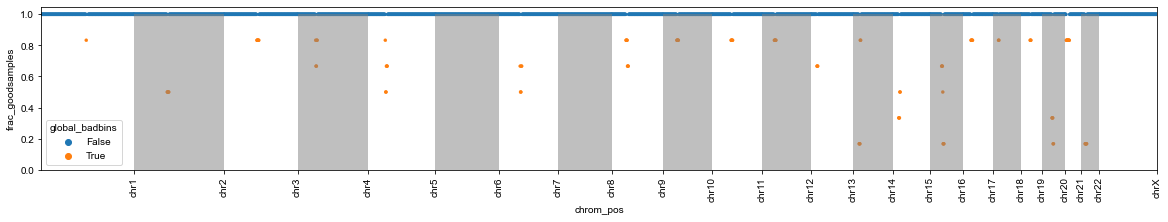

In [22]:
all_goodbins['global_badbins'] = (all_goodbins['frac_goodsamples']<0.99)
# all_goodbins['global_badbins'] = (all_goodbins['pos']<=6e6)
plt.figure(figsize=(20,3))
chromplot(all_goodbins, y='frac_goodsamples',x='START',hue='global_badbins');
all_goodbins['global_badbins'].value_counts()

In [23]:
# # Check 
# for f in CEMBA_*; do 
#  zcat $f/SegCopy.goodbins.goodcells.tsv.gz | cut -f1-3| tail -n+2 >> goodbins.bed
# done

In [24]:
global_badbins = all_goodbins[all_goodbins['global_badbins']][['CHR','START']]
global_badbins['END']= global_badbins['START']+1000000-1
# global_badbins[['START','END']]+=-1
# global_badbins.to_csv('global_badbins.bed',sep='\t')

global_badbins=global_badbins.set_index(['CHR','START','END'])

In [25]:
def remove_badbins(sample,
                global_badbins=global_badbins):
    # Determine bad bins and bad cells for a sample
    #
    
    copiesu = pd.read_csv(f'{sample}/SegCopy.goodbins.goodcells.tsv.gz',sep='\t',index_col=['CHR','START','END'])
    
    _,global_badbinsu=copiesu.align(global_badbins,axis=0,join='inner')
    copiesu=copiesu.drop(index=global_badbinsu.index)
    copiesu.to_csv(f'{sample}/SegCopy.global_goodbins.goodcells.tsv.gz',sep='\t')
    return 


In [26]:
with Pool() as p:
    x=list(tqdm(p.imap(remove_badbins, samples),total=len(samples)))

100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


In [27]:
# Make a list of all samples with the original and filtered number of cells
allsamples=pd.DataFrame(index=samples)
def my_ncells(sample):
    allsamples = pd.Series(name=sample)
    c1=pd.read_csv(f'{sample}/SegCopy.gz',sep='\t',index_col=['CHR','START','END'])
    allsamples['ncells'] = c1.shape[1]
    allsamples['nbins'] = c1.shape[0]
    c2=pd.read_csv(f'{sample}/SegCopy.global_goodbins.goodcells.tsv.gz',sep='\t',index_col=['CHR','START','END'])
    allsamples['ncells_filt'] = c2.shape[1]
    allsamples['nbins_filt'] = c2.shape[0]
    return allsamples


In [28]:
from multiprocessing import Pool

with Pool() as p:
    allsamples=list(tqdm(p.imap(my_ncells,samples),total=len(samples)))

  0%|          | 0/6 [00:00<?, ?it/s]/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/cndd/emukamel/conda_envs/enhancer_model/lib/python3.7/site-pac

In [29]:
allsamples = pd.concat(allsamples,axis=1).T

In [30]:
allsamples.to_csv('all_samples.filtered.tsv',sep='\t')

In [31]:
allsamples

,ncells,nbins,ncells_filt,nbins_filt
MB_EA,2347,3032,2302,2883
Luo2017_human,2888,3032,2804,2883
MB_v1,2784,3032,2705,2883
MB_EB,1304,3032,1235,2883
mCTN-2,2927,3032,2759,2883
mCTN-1,1446,3032,1369,2883
